# Spectra binned by energy

In [2]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
# from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin
from GDP_lib import root_dir

In [3]:
from dask.distributed import Client

if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    # cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    # cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=8)
    # from dask_jobqueue import PBSCluster
    # cluster = PBSCluster()
    # w = cluster.scale(jobs=8) # 5 for gps, 8 for argos
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.25:8787/status,
Dashboard: http://10.148.0.25:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.25:55628,Workers: 0
Dashboard: http://10.148.0.25:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Choose key 

In [3]:
key = "argos"  # 'gps' or 'argos'

# Load geo spectra

In [4]:
dl = int(2)
zarr_gps_geospec = os.path.join(root_dir, f"gps_geospectra_{int(dl)}.zarr")
zarr_argos_geospec = os.path.join(root_dir, f"argos_geospectra_{int(dl)}.zarr")
dsg = xr.open_zarr(zarr_gps_geospec).persist()
dsa = xr.open_zarr(zarr_argos_geospec).persist()

# Compute mean NRJ per bins 

In [5]:
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")
dfg = dd.read_parquet(parquet_gps).persist()
dfa = dd.read_parquet(parquet_argos).persist()

In [49]:
# bin geographically
def bins_geo(df, dl=2):
    lon_bins = np.arange(
        -180.0, 180.0 + dl, dl
    )  # CAUTION : add dl to upper bound (prevent from pb with last binning intervals)
    lat_bins = np.arange(-90, 90 + dl, dl)
    df["lon"] = (df["lon"] + 180) % 360 - 180
    df["lon_cut"] = df["lon"].map_partitions(pd.cut, bins=lon_bins).map(lambda x: x.mid)
    df["lat_cut"] = df["lat"].map_partitions(pd.cut, bins=lat_bins).map(lambda x: x.mid)


def norm_va(df):
    df["ven"] = np.sqrt(df["ve"] ** 2 + df["vn"] ** 2)
    df["ven2"] = df["ven"] ** 2
    df["vxy2"] = df["vxy"] ** 2


bins_geo(dfg)
bins_geo(dfa)
norm_va(dfg)
norm_va(dfa)

l_var = ["ven2", "vxy2"]
dsvg = (
    dfg[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)
dsva = (
    dfa[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)

# Merge and NRJ bins

In [53]:
dg = xr.merge([dsg, dsvg]).set_coords("ven2")
da = xr.merge([dsa, dsva]).set_coords("ven2")
dg

<xarray.Dataset>
Dimensions:     (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * frequency   (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins    (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins    (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    ven2        (lon_bins, lat_bins) float64 nan nan nan ... 0.003207 nan nan
Data variables:
    E_aen       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_ven       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_venw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins  (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>
    vxy2        (lon_bins, lat_bins) float64 nan nan nan ... 0.004961 nan nan

In [54]:
dn = 0.05
# define two-degree wide latitude bins
nrj_bins = np.arange(0, 0.5, dn)
# define a label for each bin corresponding to the central latitude
nrj_center = nrj_bins[:-1] + dn / 2

dg_nrj = (
    dg[["E_aen", "E_axy", "E_ven", "E_venw2", "E_vxy", "E_vxyw2"]]
    .groupby_bins("ven2", nrj_bins, labels=nrj_center)
    .mean("stacked_lon_bins_lat_bins")
)
da_nrj = (
    da[["E_aen", "E_axy", "E_ven", "E_venw2", "E_vxy", "E_vxyw2"]]
    .groupby_bins("ven2", nrj_bins, labels=nrj_center)
    .mean("stacked_lon_bins_lat_bins")
)

In [55]:
dg_nrj

<xarray.Dataset>
Dimensions:    (frequency: 1440, ven2_bins: 9)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * ven2_bins  (ven2_bins) float64 0.025 0.075 0.125 0.175 ... 0.325 0.375 0.425
Data variables:
    E_aen      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_axy      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_ven      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_venw2    (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_vxy      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_vxyw2    (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>

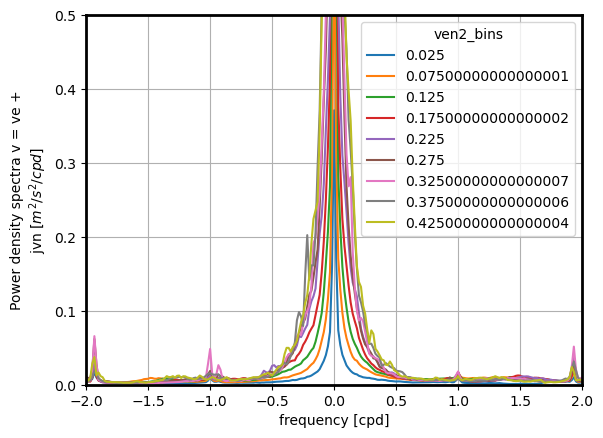

In [56]:
dg_nrj.E_ven.plot(hue="ven2_bins")
plt.xlim(-2, 2)
plt.ylim(0, 0.5)
plt.grid()

(0.0, 0.5)

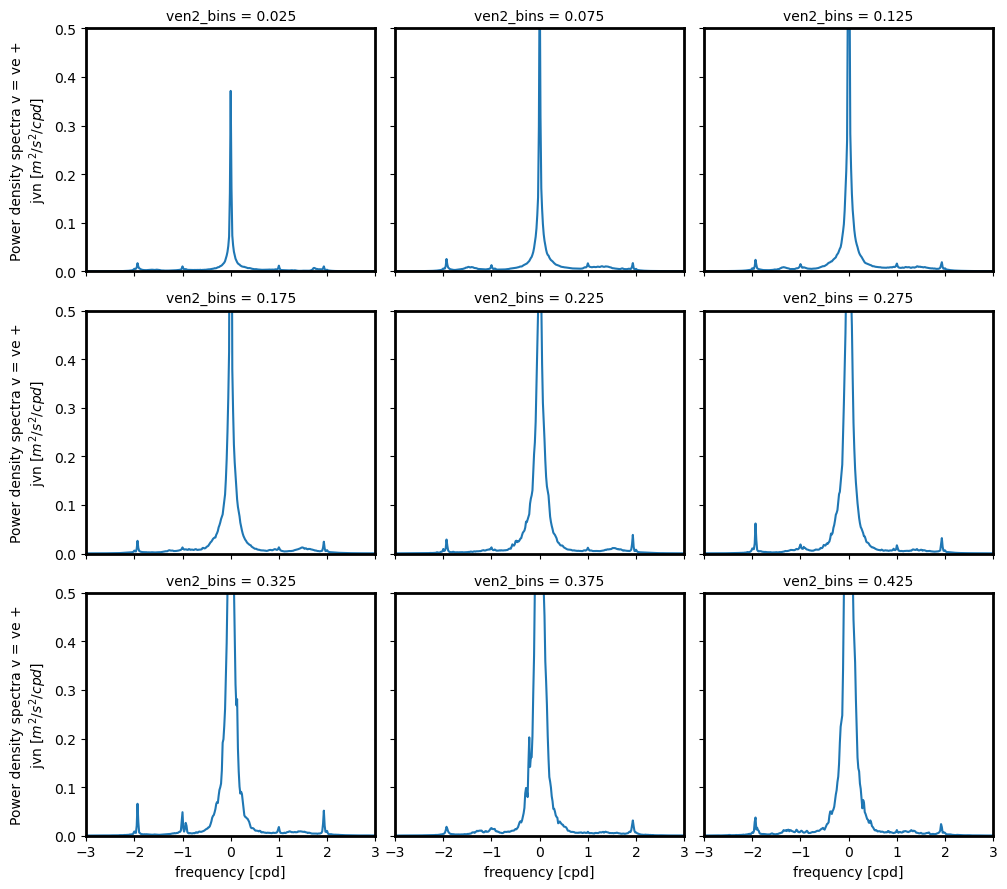

In [57]:
dg_nrj.E_ven.plot(col="ven2_bins", col_wrap=3)
plt.xlim(-3, 3)
plt.ylim(0, 0.5)


# Store nrj spectra

In [58]:
root_dir = "/home1/datawork/mdemol/GDP"
zarr_gps = os.path.join(root_dir, f"gps_nrjspectra_{dn}.zarr")
zarr_argos = os.path.join(root_dir, f"argos_nrjspectra_{dn}.zarr")
dg_nrj.to_zarr(zarr_gps, mode="w")
da_nrj.to_zarr(zarr_argos, mode="w")

In [59]:
ds_reload = xr.open_zarr(zarr_gps).persist()
ds_reload

<xarray.Dataset>
Dimensions:    (ven2_bins: 9, frequency: 1440)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * ven2_bins  (ven2_bins) float64 0.025 0.075 0.125 0.175 ... 0.325 0.375 0.425
Data variables:
    E_aen      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_axy      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_ven      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_venw2    (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_vxy      (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    E_vxyw2    (ven2_bins, frequency) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>

In [60]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
